# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
from copy import deepcopy

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Load Data

In [3]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [4]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [5]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

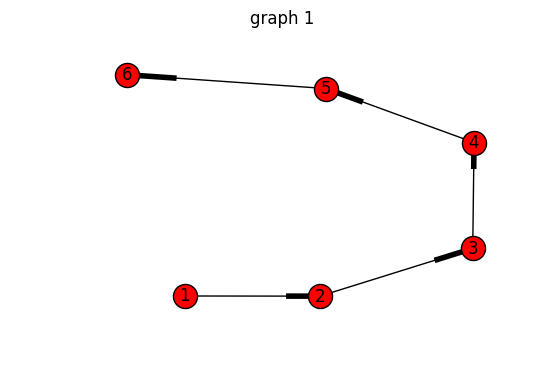

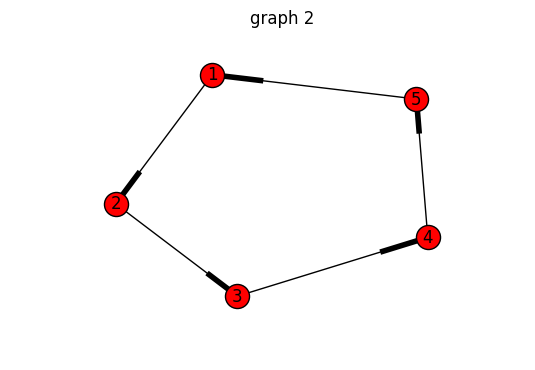

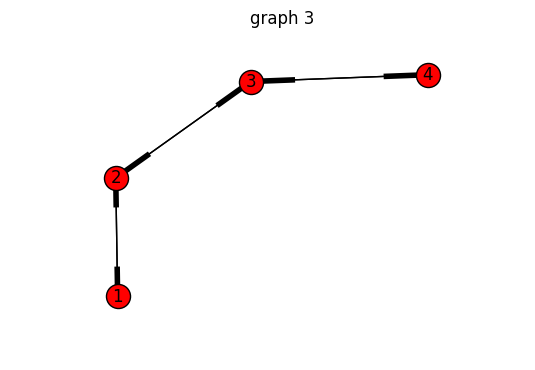

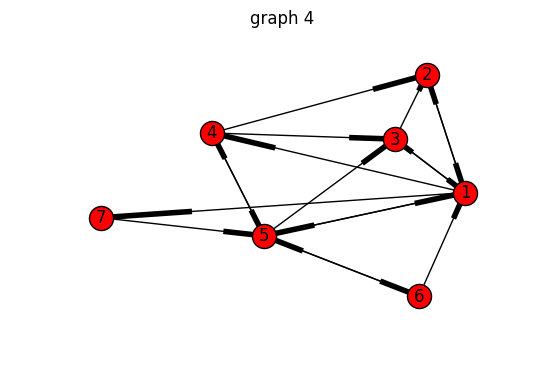

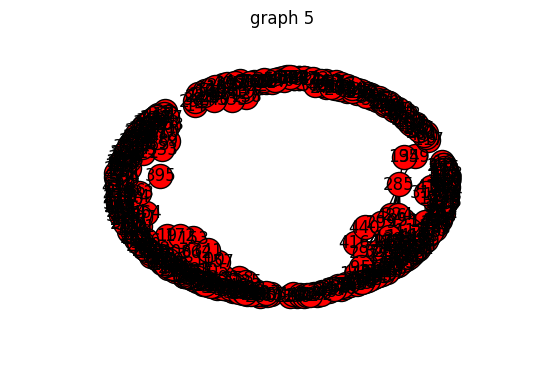

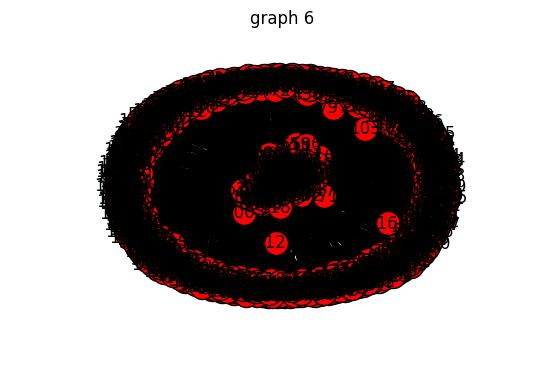

In [6]:
# Visualize  graphs
for index, graph in enumerate(graphs, 1):
    plt.figure(index)
    plt.title('graph {index}'.format(index=index))
    nx.draw(graph, arrows=True, with_labels=True)

---
# <a name='hits'></a> Hits

---
# <a name='pagerank'></a> Page Rank

In [13]:
graphs[0].nodes()

['2', '3', '5', '4', '1', '6']

In [46]:
def pagerank(graph, *, damping_factor=0.85, episilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = graph.out_degree().values()
    dangle_nodes = [
        index
        for index, o_deg in enumerate(out_degs)
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iterattion
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank each node can provide in every edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[d_n]/node_num for d_n in dangle_nodes])

        prs = (
            (1 - damping_factor) / node_num +
            damping_factor *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
    prs = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs

In [78]:
def pagerank_new(graph, *, damping_factor=0.85, episilon=1e-06):
    '''
    '''
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            (1-damping_factor) / node_num +
            damping_factor *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

In [79]:
pagerank_new(graphs[5])

{'393': 0.00085873249588616976,
 '737': 0.00092355807442578411,
 '94': 0.00071466915924053289,
 '550': 0.00075603251924653532,
 '405': 0.00069827970458340681,
 '802': 0.00078087807392803604,
 '450': 0.00072779981804395875,
 '1005': 0.00071106758421315996,
 '14': 0.00071268732143219872,
 '315': 0.00070721656422355068,
 '1203': 0.00073726743942301588,
 '535': 0.00071648639453952498,
 '979': 0.00072432426696325482,
 '1013': 0.00071081087097389086,
 '496': 0.00071861993040892545,
 '624': 0.00072737736609435142,
 '1204': 0.00084290702219154716,
 '784': 0.00073726743942301588,
 '891': 0.00072159663262944202,
 '1059': 0.00071106758421315996,
 '728': 0.00070733677612703615,
 '827': 0.00072517819653546416,
 '55': 0.00071264160029528578,
 '931': 0.0015023783547949267,
 '954': 0.00072737736609435142,
 '831': 0.00072828186255910314,
 '1064': 0.00084290702219154716,
 '1054': 0.00070511100899940205,
 '366': 0.00091860057463367495,
 '532': 0.00070741047597741363,
 '574': 0.00076711496428266939,
 '400

In [80]:
nx.pagerank(graphs[5], alpha=0.85)

{'393': 0.000860334634046428,
 '737': 0.0009261058798458434,
 '94': 0.0007104119831087528,
 '550': 0.0007532087297562698,
 '405': 0.0006933303801255234,
 '802': 0.0007816446625169039,
 '450': 0.0007236901876488922,
 '1005': 0.0007067264677516131,
 '14': 0.0007084075965577779,
 '535': 0.0007124558417788002,
 '979': 0.0007201338050607988,
 '1013': 0.0007063133463666111,
 '2': 0.0007262672657929581,
 '624': 0.0007238923667605868,
 '1204': 0.0008459508890006704,
 '891': 0.0007177716966426315,
 '1059': 0.0007067264677516131,
 '728': 0.0007027217971181133,
 '207': 0.0007570599035149354,
 '55': 0.000708103375528129,
 '931': 0.0015300979365802966,
 '954': 0.0007238923667605868,
 '831': 0.0007252158430355177,
 '1064': 0.0008459508890006704,
 '1054': 0.0007005638465332378,
 '366': 0.0009224886594255079,
 '265': 0.0007487893083937476,
 '574': 0.0007651418118457199,
 '400': 0.0007102108566952772,
 '281': 0.0008121332672846442,
 '298': 0.0015523236305758318,
 '592': 0.0007005638465332378,
 '348': 0

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

---
# <a name='simrank'></a> SimRank